In [1]:
!nvidia-smi

Wed Oct  4 01:24:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P0              17W / 140W |      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
from torch import optim
from torchvision import datasets,transforms
from torchsummary import summary

In [3]:
from transformations import train_transforms,test_transforms

In [4]:
from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer

In [5]:
# ALbumentation
# train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
# test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)

# cifar = CIFAR10DataLoader()
# train_loader,test_loader = cifar.get_loader(train_dataset,test_dataset)

In [6]:
cifar = CIFAR10DataLoader()
simple_train_loader , simple_test_loader = cifar.get_loader(
    CIFAR10Dataset(root='../data/',train=True,Atransforms=test_transforms,download=False),
    CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
)

# Model

**Objective**
- squeeze expand structure from last session
- rf 44<
- not care about 200k
- 50 epoch
- no augmentation 
**Results**

In [7]:
# We used this Squeeze-Expand Network before
class Net1(nn.Module):
    def __init__(self):
        super(Net1,self).__init__()
        self.dp_rate = 0.2

        self.conv1 = nn.Sequential(
            ConvLayer(inc=3,outc=8,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=8,outc=24,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=24,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
        )
        self.trans1 = TransBlock(32,24)
        self.conv2 = nn.Sequential(
            ConvLayer(inc=24,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
        )
        self.trans2 = TransBlock(64,32)
        self.conv3 = nn.Sequential(
            ConvLayer(inc=32,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=64,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=64,outc=128,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
        )
        self.trans3 = TransBlock(128,64)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=1,bias=False,)
        )
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Conv2d(128,10,kernel_size=1,bias=False)
    def forward(self,x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.trans3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = self.out(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [8]:
simple_model = Net1().to(device)
summary(simple_model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
         Dropout2d-4            [-1, 8, 32, 32]               0
         ConvLayer-5            [-1, 8, 32, 32]               0
            Conv2d-6           [-1, 24, 32, 32]           1,728
       BatchNorm2d-7           [-1, 24, 32, 32]              48
              ReLU-8           [-1, 24, 32, 32]               0
         Dropout2d-9           [-1, 24, 32, 32]               0
        ConvLayer-10           [-1, 24, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           6,912
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
        Dropout2d-14           [-1, 32,

In [9]:
prev_test_loss = float('inf')

optimizer = optim.SGD(simple_model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(simple_model, simple_train_loader, optimizer, criterion, device)
tester = Tester(simple_model, simple_test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(simple_model.state_dict(),'./bmodels/simple_model_with_mp_rf44.pth')
    scheduler.step(test_loss)


EPOCH = 1 | LR = 0.2 | Loss = 1.89 | Batch = 390 | Accuracy = 23.78: 100%|█| 391/391 [00:12<00:00, 30.46it/s


Test set: Average loss: 0.0142, Accuracy: 3263/10000 (32.63%)


EPOCH = 2 | LR = 0.2 | Loss = 1.67 | Batch = 390 | Accuracy = 32.30: 100%|█| 391/391 [00:13<00:00, 30.02it/s


Test set: Average loss: 0.0129, Accuracy: 3851/10000 (38.51%)


EPOCH = 3 | LR = 0.2 | Loss = 1.79 | Batch = 390 | Accuracy = 36.73: 100%|█| 391/391 [00:12<00:00, 31.13it/s


Test set: Average loss: 0.0122, Accuracy: 4297/10000 (42.97%)


EPOCH = 4 | LR = 0.2 | Loss = 1.59 | Batch = 390 | Accuracy = 39.65: 100%|█| 391/391 [00:12<00:00, 30.63it/s


Test set: Average loss: 0.0121, Accuracy: 4241/10000 (42.41%)


EPOCH = 5 | LR = 0.2 | Loss = 1.45 | Batch = 390 | Accuracy = 41.95: 100%|█| 391/391 [00:12<00:00, 30.80it/s


Test set: Average loss: 0.0112, Accuracy: 4723/10000 (47.23%)


EPOCH = 6 | LR = 0.2 | Loss = 1.49 | Batch = 390 | Accuracy = 44.06: 100%|█| 391/391 [00:12<00:00, 30.84it/s


Test set: Average loss: 0.0114, Accuracy: 4857/10000 (48.57%)


EPOCH = 7 | LR = 0.2 | Loss = 1.41 | Batch = 390 | Accuracy = 46.35: 100%|█| 391/391 [00:12<00:00, 30.70it/s


Test set: Average loss: 0.0108, Accuracy: 5061/10000 (50.61%)


EPOCH = 8 | LR = 0.2 | Loss = 1.57 | Batch = 390 | Accuracy = 48.22: 100%|█| 391/391 [00:12<00:00, 30.84it/s


Test set: Average loss: 0.0103, Accuracy: 5372/10000 (53.72%)


EPOCH = 9 | LR = 0.2 | Loss = 1.35 | Batch = 390 | Accuracy = 51.11: 100%|█| 391/391 [00:12<00:00, 30.86it/s


Test set: Average loss: 0.0097, Accuracy: 5503/10000 (55.03%)


EPOCH = 10 | LR = 0.2 | Loss = 1.19 | Batch = 390 | Accuracy = 52.85: 100%|█| 391/391 [00:12<00:00, 30.84it/


Test set: Average loss: 0.0087, Accuracy: 6034/10000 (60.34%)


EPOCH = 11 | LR = 0.2 | Loss = 1.24 | Batch = 390 | Accuracy = 54.76: 100%|█| 391/391 [00:12<00:00, 30.79it/


Test set: Average loss: 0.0086, Accuracy: 6187/10000 (61.87%)


EPOCH = 12 | LR = 0.2 | Loss = 1.32 | Batch = 390 | Accuracy = 56.38: 100%|█| 391/391 [00:12<00:00, 30.35it/


Test set: Average loss: 0.0089, Accuracy: 6054/10000 (60.54%)


EPOCH = 13 | LR = 0.2 | Loss = 1.05 | Batch = 390 | Accuracy = 57.99: 100%|█| 391/391 [00:12<00:00, 31.09it/


Test set: Average loss: 0.0081, Accuracy: 6411/10000 (64.11%)


EPOCH = 14 | LR = 0.2 | Loss = 1.04 | Batch = 390 | Accuracy = 59.24: 100%|█| 391/391 [00:12<00:00, 31.07it/


Test set: Average loss: 0.0086, Accuracy: 6214/10000 (62.14%)


EPOCH = 15 | LR = 0.2 | Loss = 1.09 | Batch = 390 | Accuracy = 59.94: 100%|█| 391/391 [00:12<00:00, 31.11it/


Test set: Average loss: 0.0076, Accuracy: 6649/10000 (66.49%)


EPOCH = 16 | LR = 0.2 | Loss = 1.30 | Batch = 390 | Accuracy = 61.43: 100%|█| 391/391 [00:12<00:00, 31.05it/


Test set: Average loss: 0.0074, Accuracy: 6772/10000 (67.72%)


EPOCH = 17 | LR = 0.2 | Loss = 1.16 | Batch = 390 | Accuracy = 61.89: 100%|█| 391/391 [00:12<00:00, 31.11it/


Test set: Average loss: 0.0077, Accuracy: 6624/10000 (66.24%)


EPOCH = 18 | LR = 0.2 | Loss = 1.00 | Batch = 390 | Accuracy = 62.85: 100%|█| 391/391 [00:12<00:00, 31.46it/


Test set: Average loss: 0.0071, Accuracy: 6935/10000 (69.35%)


EPOCH = 19 | LR = 0.2 | Loss = 1.23 | Batch = 390 | Accuracy = 63.32: 100%|█| 391/391 [00:12<00:00, 31.35it/


Test set: Average loss: 0.0070, Accuracy: 6896/10000 (68.96%)


EPOCH = 20 | LR = 0.2 | Loss = 0.85 | Batch = 390 | Accuracy = 64.04: 100%|█| 391/391 [00:12<00:00, 30.81it/


Test set: Average loss: 0.0069, Accuracy: 6916/10000 (69.16%)


EPOCH = 21 | LR = 0.2 | Loss = 0.79 | Batch = 390 | Accuracy = 64.92: 100%|█| 391/391 [00:14<00:00, 26.86it/


Test set: Average loss: 0.0068, Accuracy: 6987/10000 (69.87%)


EPOCH = 22 | LR = 0.2 | Loss = 0.97 | Batch = 390 | Accuracy = 65.80: 100%|█| 391/391 [00:14<00:00, 26.18it/


Test set: Average loss: 0.0068, Accuracy: 6982/10000 (69.82%)


EPOCH = 23 | LR = 0.2 | Loss = 0.96 | Batch = 390 | Accuracy = 66.22: 100%|█| 391/391 [00:14<00:00, 27.00it/


Test set: Average loss: 0.0072, Accuracy: 6883/10000 (68.83%)


EPOCH = 24 | LR = 0.2 | Loss = 0.89 | Batch = 390 | Accuracy = 67.02: 100%|█| 391/391 [00:14<00:00, 26.39it/


Test set: Average loss: 0.0069, Accuracy: 6959/10000 (69.59%)


EPOCH = 25 | LR = 0.2 | Loss = 1.17 | Batch = 390 | Accuracy = 67.03: 100%|█| 391/391 [00:14<00:00, 26.82it/


Test set: Average loss: 0.0062, Accuracy: 7289/10000 (72.89%)


EPOCH = 26 | LR = 0.2 | Loss = 0.95 | Batch = 390 | Accuracy = 67.80: 100%|█| 391/391 [00:14<00:00, 26.99it/


Test set: Average loss: 0.0067, Accuracy: 7087/10000 (70.87%)


EPOCH = 27 | LR = 0.2 | Loss = 0.67 | Batch = 390 | Accuracy = 68.32: 100%|█| 391/391 [00:11<00:00, 35.29it/


Test set: Average loss: 0.0065, Accuracy: 7156/10000 (71.56%)


EPOCH = 28 | LR = 0.2 | Loss = 0.99 | Batch = 390 | Accuracy = 68.76: 100%|█| 391/391 [00:12<00:00, 31.16it/


Test set: Average loss: 0.0063, Accuracy: 7258/10000 (72.58%)


EPOCH = 29 | LR = 0.2 | Loss = 0.86 | Batch = 390 | Accuracy = 68.80: 100%|█| 391/391 [00:12<00:00, 30.70it/


Test set: Average loss: 0.0059, Accuracy: 7437/10000 (74.37%)


EPOCH = 30 | LR = 0.2 | Loss = 1.12 | Batch = 390 | Accuracy = 69.28: 100%|█| 391/391 [00:12<00:00, 31.37it/


Test set: Average loss: 0.0060, Accuracy: 7391/10000 (73.91%)


EPOCH = 31 | LR = 0.2 | Loss = 0.68 | Batch = 390 | Accuracy = 69.82: 100%|█| 391/391 [00:12<00:00, 31.35it/


Test set: Average loss: 0.0063, Accuracy: 7228/10000 (72.28%)


EPOCH = 32 | LR = 0.2 | Loss = 0.74 | Batch = 390 | Accuracy = 70.11: 100%|█| 391/391 [00:12<00:00, 31.33it/


Test set: Average loss: 0.0061, Accuracy: 7306/10000 (73.06%)


EPOCH = 33 | LR = 0.2 | Loss = 1.07 | Batch = 390 | Accuracy = 70.71: 100%|█| 391/391 [00:12<00:00, 31.26it/


Test set: Average loss: 0.0058, Accuracy: 7447/10000 (74.47%)


EPOCH = 34 | LR = 0.2 | Loss = 1.14 | Batch = 390 | Accuracy = 70.85: 100%|█| 391/391 [00:12<00:00, 31.01it/


Test set: Average loss: 0.0061, Accuracy: 7331/10000 (73.31%)


EPOCH = 35 | LR = 0.2 | Loss = 0.92 | Batch = 390 | Accuracy = 70.77: 100%|█| 391/391 [00:12<00:00, 31.10it/


Test set: Average loss: 0.0060, Accuracy: 7411/10000 (74.11%)


EPOCH = 36 | LR = 0.2 | Loss = 0.89 | Batch = 390 | Accuracy = 71.24: 100%|█| 391/391 [00:12<00:00, 31.15it/


Test set: Average loss: 0.0057, Accuracy: 7496/10000 (74.96%)


EPOCH = 37 | LR = 0.2 | Loss = 0.82 | Batch = 390 | Accuracy = 71.19: 100%|█| 391/391 [00:12<00:00, 31.25it/


Test set: Average loss: 0.0056, Accuracy: 7591/10000 (75.91%)


EPOCH = 38 | LR = 0.2 | Loss = 0.91 | Batch = 390 | Accuracy = 71.86: 100%|█| 391/391 [00:12<00:00, 31.29it/


Test set: Average loss: 0.0055, Accuracy: 7605/10000 (76.05%)


EPOCH = 39 | LR = 0.2 | Loss = 0.70 | Batch = 390 | Accuracy = 71.85: 100%|█| 391/391 [00:12<00:00, 31.39it/


Test set: Average loss: 0.0056, Accuracy: 7512/10000 (75.12%)


EPOCH = 40 | LR = 0.2 | Loss = 0.91 | Batch = 390 | Accuracy = 72.06: 100%|█| 391/391 [00:12<00:00, 31.37it/


Test set: Average loss: 0.0056, Accuracy: 7547/10000 (75.47%)


EPOCH = 41 | LR = 0.2 | Loss = 0.71 | Batch = 390 | Accuracy = 72.50: 100%|█| 391/391 [00:12<00:00, 31.25it/


Test set: Average loss: 0.0055, Accuracy: 7647/10000 (76.47%)


EPOCH = 42 | LR = 0.2 | Loss = 0.78 | Batch = 390 | Accuracy = 72.31: 100%|█| 391/391 [00:12<00:00, 31.17it/


Test set: Average loss: 0.0056, Accuracy: 7545/10000 (75.45%)


EPOCH = 43 | LR = 0.2 | Loss = 0.61 | Batch = 390 | Accuracy = 72.55: 100%|█| 391/391 [00:12<00:00, 31.27it/


Test set: Average loss: 0.0053, Accuracy: 7678/10000 (76.78%)


EPOCH = 44 | LR = 0.2 | Loss = 0.81 | Batch = 390 | Accuracy = 72.93: 100%|█| 391/391 [00:12<00:00, 31.34it/


Test set: Average loss: 0.0053, Accuracy: 7737/10000 (77.37%)


EPOCH = 45 | LR = 0.2 | Loss = 0.77 | Batch = 390 | Accuracy = 72.88: 100%|█| 391/391 [00:12<00:00, 31.61it/


Test set: Average loss: 0.0056, Accuracy: 7572/10000 (75.72%)


EPOCH = 46 | LR = 0.2 | Loss = 0.76 | Batch = 390 | Accuracy = 73.19: 100%|█| 391/391 [00:12<00:00, 31.09it/


Test set: Average loss: 0.0055, Accuracy: 7580/10000 (75.80%)


EPOCH = 47 | LR = 0.2 | Loss = 0.87 | Batch = 390 | Accuracy = 73.42: 100%|█| 391/391 [00:12<00:00, 31.30it/


Test set: Average loss: 0.0053, Accuracy: 7711/10000 (77.11%)


EPOCH = 48 | LR = 0.2 | Loss = 0.73 | Batch = 390 | Accuracy = 73.68: 100%|█| 391/391 [00:12<00:00, 31.35it/


Test set: Average loss: 0.0055, Accuracy: 7644/10000 (76.44%)


EPOCH = 49 | LR = 0.2 | Loss = 0.95 | Batch = 390 | Accuracy = 73.86: 100%|█| 391/391 [00:12<00:00, 31.10it/


Test set: Average loss: 0.0055, Accuracy: 7617/10000 (76.17%)


EPOCH = 50 | LR = 0.2 | Loss = 0.74 | Batch = 390 | Accuracy = 74.03: 100%|█| 391/391 [00:12<00:00, 31.42it/


Test set: Average loss: 0.0053, Accuracy: 7682/10000 (76.82%)


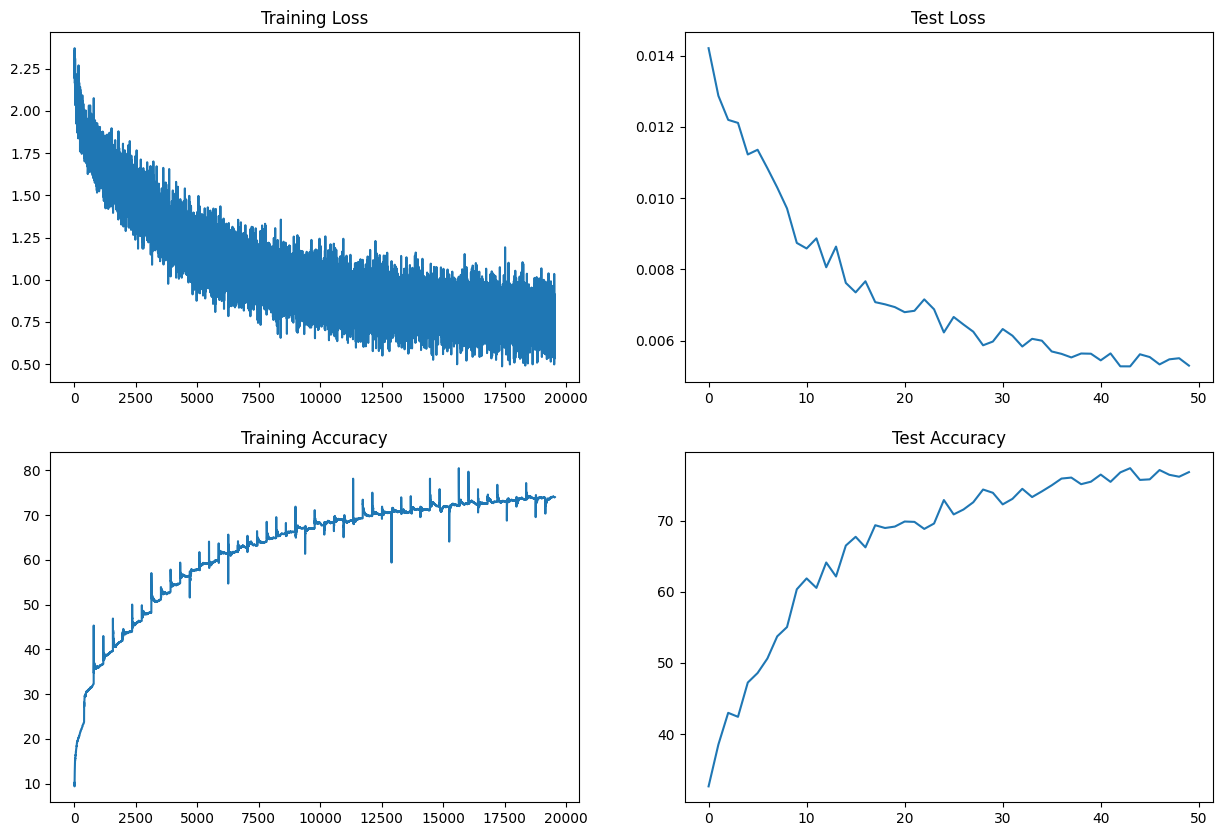

In [10]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Model-2

**Objective**
- remove MP
- use strided instead
- rest same as previous model

**Results**
-
-

In [11]:
# We used this Squeeze-Expand Network before
class Net2(nn.Module):
    def __init__(self,dp:int):
        super(Net2,self).__init__()
        self.dp_rate = dp

        self.conv1 = nn.Sequential(
            ConvLayer(inc=3,outc=8,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=8,outc=24,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=24,outc=32,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate),
        )
        # self.trans1 = TransBlock(32,24)
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=24,kernel_size=1,bias=False)
        )
        self.conv2 = nn.Sequential(
            ConvLayer(inc=24,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=64,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate),
        )
        # self.trans2 = TransBlock(64,32)
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=1,bias=False)
        )
        
        self.conv3 = nn.Sequential(
            ConvLayer(inc=32,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=64,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=64,outc=128,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate),
        )
        # self.trans3 = TransBlock(128,64)
        self.trans3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=1,bias=False)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=1,bias=False,)
        )
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Conv2d(128,10,kernel_size=1,bias=False)
    def forward(self,x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.trans3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = self.out(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [12]:
model2_removed_mp = Net2(0.2).to(device)
summary(model2_removed_mp,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
         Dropout2d-4            [-1, 8, 32, 32]               0
         ConvLayer-5            [-1, 8, 32, 32]               0
            Conv2d-6           [-1, 24, 32, 32]           1,728
       BatchNorm2d-7           [-1, 24, 32, 32]              48
              ReLU-8           [-1, 24, 32, 32]               0
         Dropout2d-9           [-1, 24, 32, 32]               0
        ConvLayer-10           [-1, 24, 32, 32]               0
           Conv2d-11           [-1, 32, 16, 16]           6,912
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
        Dropout2d-14           [-1, 32,

In [13]:
prev_test_loss = float('inf')

optimizer = optim.SGD(model2_removed_mp.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model2_removed_mp, simple_train_loader, optimizer, criterion, device)
tester = Tester(model2_removed_mp, simple_test_loader, criterion, device)

for epoch in range(1, 21):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(simple_model.state_dict(),'./bmodels/model1_without_mp.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.2 | Loss = 1.81 | Batch = 390 | Accuracy = 23.08: 100%|█| 391/391 [00:12<00:00, 31.47it/s


Test set: Average loss: 0.0142, Accuracy: 3206/10000 (32.06%)


EPOCH = 2 | LR = 0.2 | Loss = 1.60 | Batch = 390 | Accuracy = 32.29: 100%|█| 391/391 [00:12<00:00, 31.28it/s


Test set: Average loss: 0.0132, Accuracy: 3776/10000 (37.76%)


EPOCH = 3 | LR = 0.2 | Loss = 1.51 | Batch = 390 | Accuracy = 37.35: 100%|█| 391/391 [00:12<00:00, 30.93it/s


Test set: Average loss: 0.0124, Accuracy: 4036/10000 (40.36%)


EPOCH = 4 | LR = 0.2 | Loss = 1.59 | Batch = 390 | Accuracy = 40.02: 100%|█| 391/391 [00:12<00:00, 31.09it/s


Test set: Average loss: 0.0118, Accuracy: 4506/10000 (45.06%)


EPOCH = 5 | LR = 0.2 | Loss = 1.57 | Batch = 390 | Accuracy = 42.37: 100%|█| 391/391 [00:12<00:00, 30.75it/s


Test set: Average loss: 0.0109, Accuracy: 4894/10000 (48.94%)


EPOCH = 6 | LR = 0.2 | Loss = 1.65 | Batch = 390 | Accuracy = 44.18: 100%|█| 391/391 [00:12<00:00, 30.92it/s


Test set: Average loss: 0.0109, Accuracy: 4977/10000 (49.77%)


EPOCH = 7 | LR = 0.2 | Loss = 1.36 | Batch = 390 | Accuracy = 46.52: 100%|█| 391/391 [00:12<00:00, 31.49it/s


Test set: Average loss: 0.0101, Accuracy: 5420/10000 (54.20%)


EPOCH = 8 | LR = 0.2 | Loss = 1.39 | Batch = 390 | Accuracy = 48.60: 100%|█| 391/391 [00:12<00:00, 30.78it/s


Test set: Average loss: 0.0097, Accuracy: 5579/10000 (55.79%)


EPOCH = 9 | LR = 0.2 | Loss = 1.45 | Batch = 390 | Accuracy = 50.10: 100%|█| 391/391 [00:12<00:00, 31.31it/s


Test set: Average loss: 0.0098, Accuracy: 5528/10000 (55.28%)


EPOCH = 10 | LR = 0.2 | Loss = 1.41 | Batch = 390 | Accuracy = 51.89: 100%|█| 391/391 [00:12<00:00, 31.22it/


Test set: Average loss: 0.0092, Accuracy: 5766/10000 (57.66%)


EPOCH = 11 | LR = 0.2 | Loss = 1.38 | Batch = 390 | Accuracy = 53.37: 100%|█| 391/391 [00:12<00:00, 30.95it/


Test set: Average loss: 0.0093, Accuracy: 5837/10000 (58.37%)


EPOCH = 12 | LR = 0.2 | Loss = 1.14 | Batch = 390 | Accuracy = 54.30: 100%|█| 391/391 [00:12<00:00, 31.10it/


Test set: Average loss: 0.0085, Accuracy: 6071/10000 (60.71%)


EPOCH = 13 | LR = 0.2 | Loss = 1.25 | Batch = 390 | Accuracy = 55.52: 100%|█| 391/391 [00:12<00:00, 31.28it/


Test set: Average loss: 0.0091, Accuracy: 5916/10000 (59.16%)


EPOCH = 14 | LR = 0.2 | Loss = 1.22 | Batch = 390 | Accuracy = 56.36: 100%|█| 391/391 [00:12<00:00, 30.89it/


Test set: Average loss: 0.0083, Accuracy: 6244/10000 (62.44%)


EPOCH = 15 | LR = 0.2 | Loss = 1.08 | Batch = 390 | Accuracy = 57.23: 100%|█| 391/391 [00:12<00:00, 31.44it/


Test set: Average loss: 0.0085, Accuracy: 6189/10000 (61.89%)


EPOCH = 16 | LR = 0.2 | Loss = 1.18 | Batch = 390 | Accuracy = 58.41: 100%|█| 391/391 [00:12<00:00, 31.50it/


Test set: Average loss: 0.0080, Accuracy: 6467/10000 (64.67%)


EPOCH = 17 | LR = 0.2 | Loss = 0.99 | Batch = 390 | Accuracy = 59.13: 100%|█| 391/391 [00:12<00:00, 31.08it/


Test set: Average loss: 0.0081, Accuracy: 6450/10000 (64.50%)


EPOCH = 18 | LR = 0.2 | Loss = 1.47 | Batch = 390 | Accuracy = 59.77: 100%|█| 391/391 [00:12<00:00, 31.02it/


Test set: Average loss: 0.0077, Accuracy: 6567/10000 (65.67%)


EPOCH = 19 | LR = 0.2 | Loss = 1.15 | Batch = 390 | Accuracy = 60.54: 100%|█| 391/391 [00:12<00:00, 31.11it/


Test set: Average loss: 0.0074, Accuracy: 6636/10000 (66.36%)


EPOCH = 20 | LR = 0.2 | Loss = 1.31 | Batch = 390 | Accuracy = 60.70: 100%|█| 391/391 [00:12<00:00, 30.92it/


Test set: Average loss: 0.0074, Accuracy: 6725/10000 (67.25%)


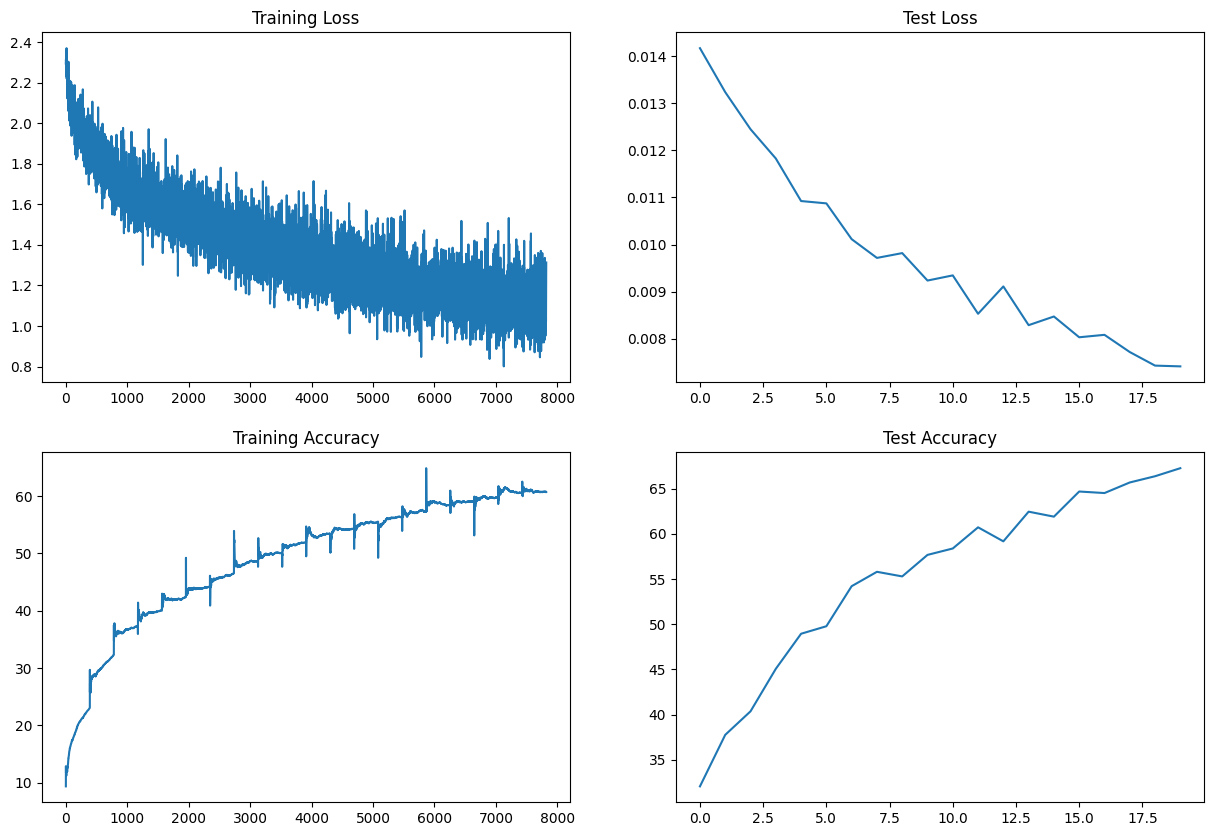

In [14]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Model

## normal model ( no conditions apply)

## shrink model  (200k params)

## remove maxpool but 3 conv

## dialated kernels

## depth-wise kernel

## all depth-wise kernel

## apply albumentation